# Import Required Libraries
Import necessary libraries such as matplotlib and pollution_extraction modules.

In [2]:
import matplotlib.pyplot as plt

from pollution_extraction.core import DataExporter
from pollution_extraction.core.data_reader import PollutionDataReader
from pollution_extraction.core.data_visualizer import DataVisualizer
from pollution_extraction.core.spatial_extractor import SpatialExtractor

# Initialize PollutionDataReader
Initialize PollutionDataReader with the NetCDF file path and pollution type.

In [3]:
file_path = "/workspaces/dss-pollution-extraction/PM2p5_downscaled_daily_lr_2006_01.nc"
reader = PollutionDataReader(file_path, pollution_type="pm25")

2025-06-04 19:26:17,484 - pollution_extraction.core.data_reader - INFO - Successfully loaded dataset from /workspaces/dss-pollution-extraction/PM2p5_downscaled_daily_lr_2006_01.nc


# Inspect Dataset Information
Print dataset shape, basic information, time range, and spatial bounds.

In [4]:
data = reader.data_variable
print("\nData variable shape:", data.shape)
info = reader.get_basic_info()
print("\nBasic Info:")
for k, v in info.items():
    print(f"  {k}: {v}")
print("\nTime range:", reader.time_range)
print("Spatial bounds:", reader.spatial_bounds)


Data variable shape: (31, 4037, 3890)

Basic Info:
  file_path: /workspaces/dss-pollution-extraction/PM2p5_downscaled_daily_lr_2006_01.nc
  pollution_type: pm25
  variable_name: PM2p5_downscaled
  units: μg/m³
  description: PM2.5 Concentration
  time_range: (Timestamp('2006-01-01 00:00:00'), Timestamp('2006-01-31 00:00:00'))
  total_time_steps: 31
  spatial_dimensions: {'x': 3890, 'y': 4037}
  spatial_bounds: {'x_min': 2636500.0, 'x_max': 6525500.0, 'y_min': 1386500.0, 'y_max': 5422500.0}
  coordinate_system: {'grid_mapping_name': 'lambert_azimuthal_equal_area', 'longitude_of_projection_origin': np.float64(10.0), 'latitude_of_projection_origin': np.float64(52.0), 'false_easting': np.float64(4321000.0), 'false_northing': np.float64(3210000.0), 'crs_wkt': 'PROJCS["ETRS89-extended / LAEA Europe",\n                GEOGCS["ETRS89",\n                    DATUM["European_Terrestrial_Reference_System_1989",\n                        SPHEROID["GRS 1980",6378137,298.257222101,\n                 

# Subset Data by Time
Select a subset of data for the first 7 days and print its shape.

In [5]:
subset = data.isel(time=slice(0, 7))
print("\nSubset shape (first 7 days):", subset.shape)


Subset shape (first 7 days): (7, 4037, 3890)


# Visualize First Time Slice
Plot the first time slice using xarray or matplotlib with controlled vmin/vmax.


First slice stats:
  min: 0.0
  max: 168.5326385498047
  mean: 11.246780395507812


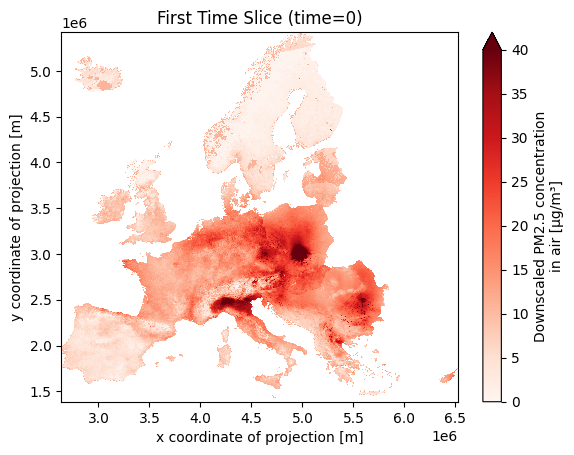

In [6]:
first_slice = data.isel(time=0).clip(min=0)
print("\nFirst slice stats:")
print("  min:", float(first_slice.min().values))
print("  max:", float(first_slice.max().values))
print("  mean:", float(first_slice.mean().values))
try:
    first_slice.plot.imshow(vmin=0, vmax=40, cmap="Reds", origin="upper")
    plt.title("First Time Slice (time=0)")
    plt.show()
except Exception:
    plt.imshow(first_slice.values, origin="upper", vmin=0, vmax=40, cmap="Reds")
    plt.title("First Time Slice (time=0) [imshow fallback]")
    plt.colorbar()
    plt.show()

# Compute Monthly Average
Calculate the monthly average (mean over time) and visualize it.


Time-averaged (monthly mean) shape: (4037, 3890)


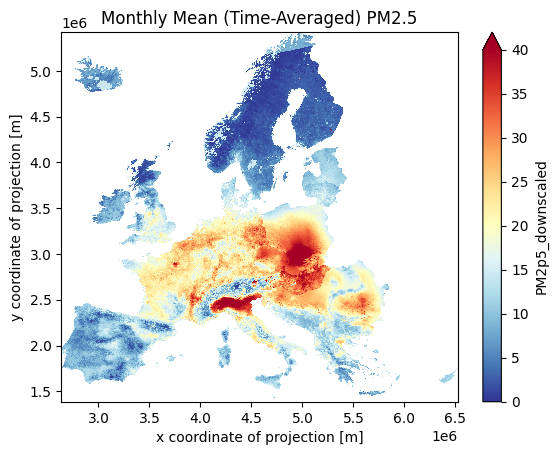

In [7]:
dataset = reader.dataset
var_name = reader.variable_info["var_name"]
time_avg = dataset[var_name].mean(dim="time").clip(min=0)
print("\nTime-averaged (monthly mean) shape:", time_avg.shape)
time_avg.plot.imshow(vmin=0, vmax=40, cmap="RdYlBu_r", origin="upper")
plt.title("Monthly Mean (Time-Averaged) PM2.5")
plt.show()

# Extract Spatial Point
Extract the value at the center of the spatial domain using SpatialExtractor.

In [8]:
spatial_ext = SpatialExtractor(dataset, var_name)
x_center = float(
    reader.spatial_bounds["x_min"]
    + (reader.spatial_bounds["x_max"] - reader.spatial_bounds["x_min"]) / 2
)
y_center = float(
    reader.spatial_bounds["y_min"]
    + (reader.spatial_bounds["y_max"] - reader.spatial_bounds["y_min"]) / 2
)
try:
    point_result = spatial_ext.extract_points([(x_center, y_center)], method="nearest")
    print(
        f"\nExtracted value at domain center (x={x_center:.1f}, y={y_center:.1f}):\n",
        point_result,
    )
except KeyError as e:
    print(
        f"\n[SpatialExtractor] Extraction failed: {e}\nCheck if the coordinates are within the valid range and match the dataset's CRS."
    )


Extracted value at domain center (x=4581000.0, y=3404500.0):
 <xarray.Dataset> Size: 404B
Dimensions:           (location_id: 1, time: 31)
Coordinates:
  * time              (time) datetime64[ns] 248B 2006-01-01 ... 2006-01-31
    y                 float64 8B 3.404e+06
    x                 float64 8B 4.582e+06
    crs               int64 8B 0
  * location_id       (location_id) int64 8B 0
Data variables:
    PM2p5_downscaled  (location_id, time) float32 124B dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/18)
    Conventions:            CF-1.8
    title:                  High-resolution PM2.5 concentration downscaled fo...
    institution:            Alfred Wegener Institute (AWI)
    source:                 Enhanced dual linear regression model: full model...
    history:                Created on 2025-05-27 16:24:47 UTC
    references:             Dual Linear Regression with enhanced correction f...
    ...                     ...
    geospatial_bounds_crs:  EPSG:3035

# Export Data to GeoTIFF
Demonstrate exporting the time-averaged map to GeoTIFF using DataExporter.

In [ ]:
exporter = DataExporter(dataset, var_name)
exporter.to_geotiff(
    "/workspaces/dss-pollution-extraction/monthly_mean_pm25.tif",
    time_index=slice(None),
    aggregation_method="mean",
)
print("\n[DataExporter] Example: exporter.to_geotiff() can export data.")

# Custom Visualization
Use DataVisualizer to create a custom plot for a specific time index.

Data shape: (4037, 3890)
Data range: -2.764932870864868 to 168.5326385498047
Data coordinates:
  x: [2636500. 2637500. 2638500. 2639500. 2640500.]...[6521500. 6522500. 6523500. 6524500. 6525500.] (first/last 5)
  y: [5422500. 5421500. 5420500. 5419500. 5418500.]...[1390500. 1389500. 1388500. 1387500. 1386500.] (first/last 5)
Data has NaN values: True


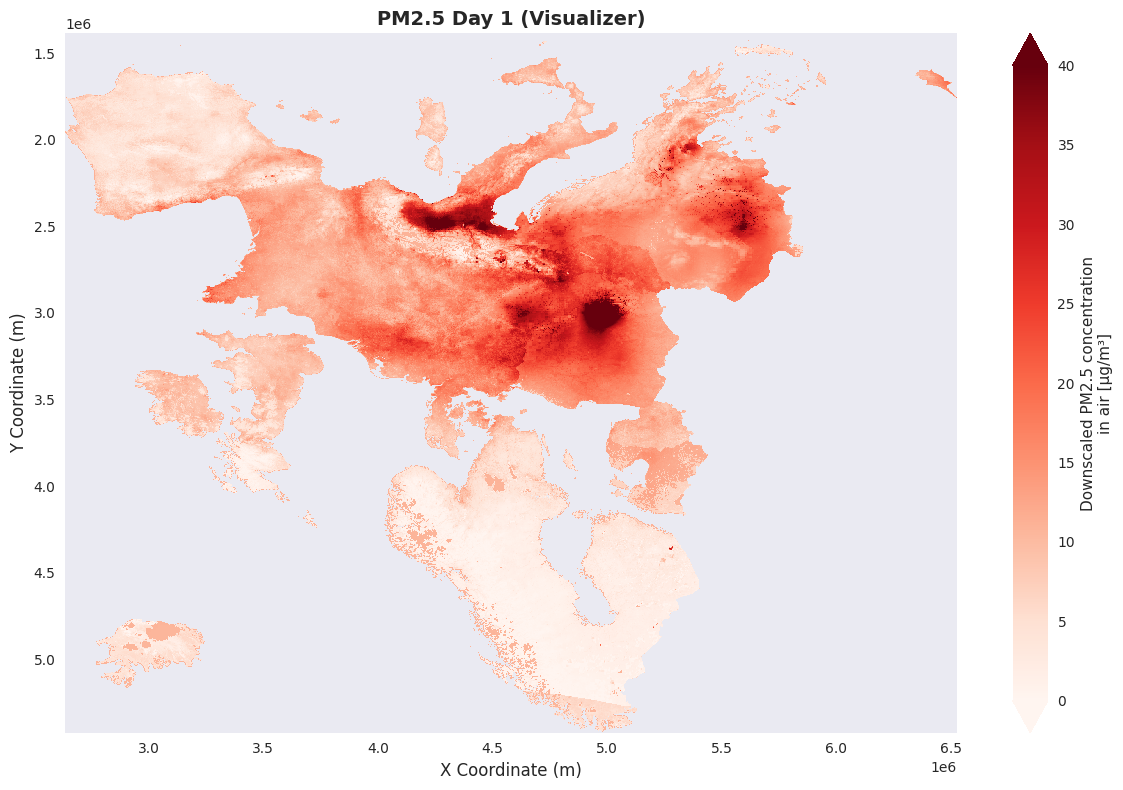

2025-06-04 19:40:38,946 - pollution_extraction.core.data_reader - INFO - Dataset closed


In [12]:
visualizer = DataVisualizer(dataset, var_name, reader.pollution_type)
fig = visualizer.plot_spatial_map(
    time_index=0, vmin=0, vmax=40, title="PM2.5 Day 1 (Visualizer)"
)
plt.show()
reader.close()